# Ungraded lab: Serve a model with TensorFlow Serving
------------------------


In this lab you will be taking a look at TFX's model serving system for production called [Tensorflow Serving](https://www.tensorflow.org/tfx/guide/serving). This system is highly integrated with the Tensorflow stack and provides an easy and straightforward way of deploying models.

Specifically you will:
- Learn how to install TF serving.
- Load a pretrained model that classifies dogs, birds and cats.
- Save it following the conventions needed by TF serving.
- Spin a web server using TF serving that will accept requests through HTTP.
- Interact with your model via a REST API.
- Learn about model versioning.

This lab draws inspiration from [this](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple) official Tensorflow tutorial, so check it out if you got doubts about the topics covered here.

Notice that unlike last ungraded lab, you will be working with TF serving without using Docker. This is to show you different ways in which this serving system can be used.

Let's get started!

### Imports

In [1]:
import os
import zipfile
import subprocess
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import Image, display

### Downloading the data

During this lab you are not going to train a model but to make use of one to get predictions, because of this you need some test images. The model you are going to use was originally trained using images from the datasets `cats and dogs` and `caltech birds`. To ask for predictions some images of the test set are provided:

There are 123 images of dogs
There are 123 images of cats
There are 116 images of birds


Sample cat image:


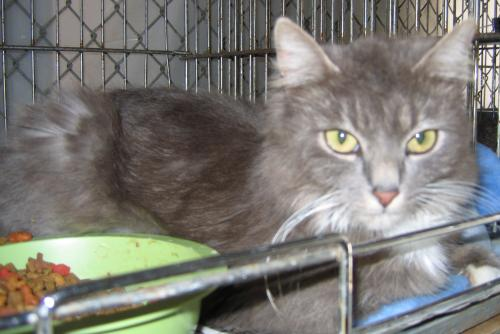


Sample dog image:


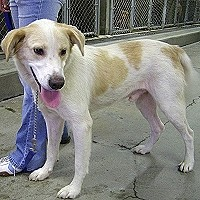


Sample bird image:


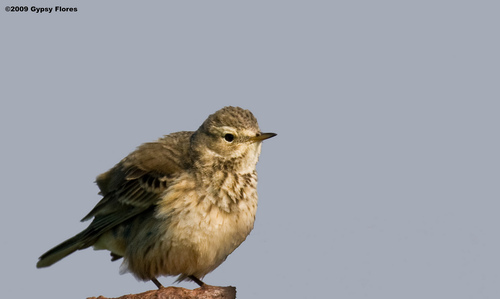

In [3]:
# Download the images
!wget -q https://storage.googleapis.com/mlep-public/course_3/week2/images.zip

# Set a base directory
base_dir = '/tmp/data'

# Unzip images
with zipfile.ZipFile('/content/images.zip', 'r') as my_zip:
  my_zip.extractall(base_dir)

# Save paths for images of each class
dogs_dir = os.path.join(base_dir, 'images/dogs')
cats_dir = os.path.join(base_dir,'images/cats')
birds_dir = os.path.join(base_dir,'images/birds')

# Print number of images for each class
print(f"There are {len(os.listdir(dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(cats_dir))} images of cats")
print(f"There are {len(os.listdir(birds_dir))} images of birds\n\n")

# Look at sample images of each class
print("Sample cat image:")
display(Image(filename=f"{os.path.join(cats_dir, os.listdir(cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(dogs_dir, os.listdir(dogs_dir)[5])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(birds_dir, os.listdir(birds_dir)[0])}"))

Now that you are familiar with the data you're going to be working with, let's jump to the model.

### Load a pretrained model

The purpose of this lab is to showcase TF serving's capabilities so you are not going to spend any time training a model. Instead you will be using a model that you trained during course 1 of the specialization. This model classifies images of birds, cats and dogs and has been trained with image augmentation so it yields really good results.

First, download the necessary files:

In [4]:
!wget -q -P /content/model/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index

Now, load the model into memory:

In [5]:
model = tf.keras.models.load_model('/content/model')

At this point you can assume you have succesfully trained the model yourself. You can ignore the warnings about the model being trained on an older version of TensorFlow.

For context, ths model uses a simple CNN architecture. Take a quick look at the layers that made it up:

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a [protobuf](https://developers.google.com/protocol-buffers) file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [7]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print(f'export_path = {export_path}\n')


# Save the model
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets


A saved model on disk includes the following files:
- `assets`: a directory including arbitrary files used by the TF graph.
- `variables`: a directory containing information about the training checkpoints of the model.
- `saved_model.pb`: the protobuf file that represents the actual TF program.

Take a quick look at these files:

In [8]:
print(f'\nFiles of model saved in {export_path }:\n')
!ls -lh {export_path}


Files of model saved in /tmp/1:

total 176K
drwxr-xr-x 2 root root 4.0K Apr 25 05:01 assets
-rw-r--r-- 1 root root  23K Apr 25 05:01 keras_metadata.pb
-rw-r--r-- 1 root root 141K Apr 25 05:01 saved_model.pb
drwxr-xr-x 2 root root 4.0K Apr 25 05:01 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](https://www.tensorflow.org/tfx/serving/signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

In [9]:
!saved_model_cli show --dir {export_path} --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['conv2d_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 150, 150, 3)
      name: serving_default_conv2d_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


That tells us a lot about our model!  In this case we didn't explicitly train the model, so any information about the inputs and outputs is very valuable. For instance we know that this model expects our inputs to be of shape `(150, 150, 3)`, which in combination with the use of `conv2d` layers suggests this model expects colored images in a resolution of `150 by 150`. Also the output of the model are of shape `(3)` suggesting a `softmax` activation with 3 classes.

## Prepare data for inference

Now that you know the shape of the data expected by the model it is time to preprocess the test images accordingly. These images come in a wide variety of resolutions, luckily Keras has you covered with its [`ImageDataGenerator`](https://keras.io/api/preprocessing/image/). Using this object you can:
- Normalize pixel values.
- Standardize image resolutions.
- Set a batch size for inference.
- And more!

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize pixel values
test_datagen = ImageDataGenerator(rescale=1./255)

# Point to the directory with the test images
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/images',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

# Print the label that is assigned to each class
print(f"labels for each class in the test generator are: {val_gen_no_shuffle.class_indices}")

Found 362 images belonging to 3 classes.
labels for each class in the test generator are: {'birds': 0, 'cats': 1, 'dogs': 2}


Since this object is a generator, you can get a batch of images and labels using the `next` function:

In [11]:
# Get a batch of 32 images along with their true label
data_imgs, labels = next(val_gen_no_shuffle)

# Check shapes
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32,)


As expected `data_imgs` is an array containing 32 colored images of 150x150 resolution. In a similar fashion `labels` has the true label for each one of these 32 images.

To check that everything is working properly, do a sanity check to plot the first 5 images in the batch:

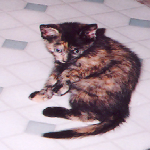

Image shows a cat.



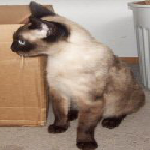

Image shows a cat.



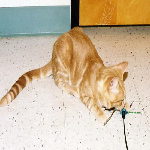

Image shows a cat.



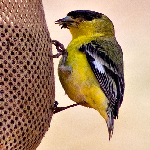

Image shows a bird.



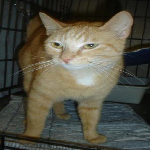

Image shows a cat.



In [12]:
from tensorflow.keras.preprocessing.image import array_to_img

# Returns string representation of each class
def get_class(index):
  if index == 0:
    return "bird"
  elif index == 1:
    return "cat"
  elif index == 2:
    return "dog"
  return None


# Plots a numpy array representing an image
def plot_array(array, label, pred=None):
  array = np.squeeze(array)
  img = array_to_img(array)
  display(img)
  if pred is None:
    print(f"Image shows a {get_class(label)}.\n")
  else:
    print(f"Image shows a {get_class(label)}. Model predicted it was {get_class(pred)}.\n")


# Plot the first 5 images in the batch
for i in range(5):
  plot_array(data_imgs[i], labels[i])

All images have the same resolution and the true labels are correct.

Let's jump to serving the model!

## Serve your model with TensorFlow Serving

### Add TensorFlow Serving distribution URI as a package source:

We're preparing to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this Colab runs in a Debian environment.  We'll add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

In [13]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  39240      0 --:--:-- --:--:-- --:--:-- 39240
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/

### Install TensorFlow Serving

This is all you need - one command line!

In [14]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 340 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.8.0 [340 MB]
Fetched 340 MB in 5s (71.3 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155501 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) ...
Setting up tensorflow-model-server (2.8.0) ...


### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything. For this case `animal_classifier` is used.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [15]:
# Define an env variable with the path to where the model is saved
os.environ["MODEL_DIR"] = MODEL_DIR

In [16]:
# Spin up TF serving server
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=animal_classifier \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


Take a look at the end of the logs printed out my TF model server:

In [17]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


The server was able to succesfully load and serve the model!

Since you are going to interact with the server through HTTP/REST, you should point the requests to `localhost:8501` as it is being printed in the logs above.

## Make a request to your model in TensorFlow Serving

At this point you already know how your test data looks like. You are going to make predictions for colored images of 150x150 in batches of 32 images (represented by numpy arrays) at a time.

Since REST expects the data to be in JSON format and JSON does not support custom Python data types such as numpy arrays you first need to convert these arrays into nested lists.

TF serving expects a field called `instances` which contains the input tensors for the model. To pass in your data to the model you should create a JSON with your data as value for the key `instances`.

In [19]:
import json

# Convert numpy array to list
data_imgs_list = data_imgs.tolist()

# Create JSON to use in the request
data = json.dumps({"instances": data_imgs_list})

### Make REST requests

We'll send a predict request as a POST request to our server's REST endpoint, and pass it the batch of 32 images. 

Remember that the endpoint that serves the model is located at `http://localhost:8501`. However this URL still needs some additional parameters to properly handle the request. You should append `v1/models/name-of-your-model:predict` to it so TF serving knows which model to look for and to perform a predict task.

You should also pass to the request the data containing the list that represents the 32 images along with a headers dictionary that specifies the type of content that will be passed, which is JSON in this case.

After you get a response from the server you can get the predictions out of it by inspecting the `predictions` field of the JSON that the response returned.

In [20]:
import requests

# Define headers with content-type set to json
headers = {"content-type": "application/json"}

# Capture the response by making a request to the appropiate URL with the appropiate parameters
json_response = requests.post('http://localhost:8501/v1/models/animal_classifier:predict', data=data, headers=headers)

# Parse the predictions out of the response
predictions = json.loads(json_response.text)['predictions']

# Print shape of predictions
print(f"predictions has shape: {np.asarray(predictions).shape}")

predictions has shape: (32, 3)


You might think it is weird that the predictions returned 3 values for each image. However, remember that the last layer of the model is a `softmax` function, so it returned a value for each one of the class. To get the actual predictions you need to find the maximum argument:

In [21]:
# Compute argmax
preds = np.argmax(predictions, axis=1)

# Print shape of predictions
print(f"preds has shape: {preds.shape}")

preds has shape: (32,)


Now you have a predicted class for each one of the test images! Nice!

To test how good the model is performing let's plot the first 10 images along with the true and predicted labels:

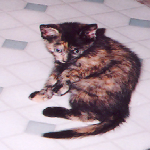

Image shows a cat. Model predicted it was dog.



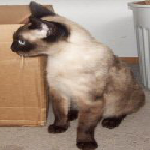

Image shows a cat. Model predicted it was dog.



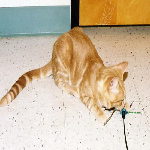

Image shows a cat. Model predicted it was dog.



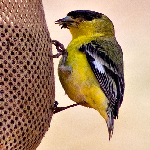

Image shows a bird. Model predicted it was bird.



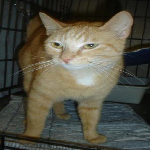

Image shows a cat. Model predicted it was cat.



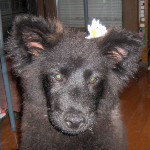

Image shows a dog. Model predicted it was cat.



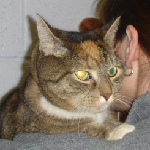

Image shows a cat. Model predicted it was cat.



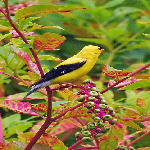

Image shows a bird. Model predicted it was bird.



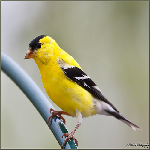

Image shows a bird. Model predicted it was bird.



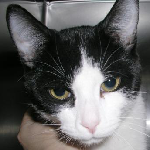

Image shows a cat. Model predicted it was cat.



In [22]:
for i in range(10):
  plot_array(data_imgs[i], labels[i], preds[i])

To do some further testing you can plot more images out of the 32 or even try to generate a new batch from the generator and repeat the steps above.

## Optional Challenge

Try to recreating the steps above for the next batch of 32 images:

In [ ]:
# Your code here



## Solution

If you want some help, the answer can be found in the next cell:

In [ ]:
# Get a batch of 32 images along with their true label
data_imgs, labels = next(val_gen_no_shuffle)

# Convert numpy array to list
data_imgs_list = data_imgs.tolist()

# Create JSON to use in the request
data = json.dumps({"instances": data_imgs_list})

# Capture the response by making a request to the appropiate URL with the appropiate parameters
json_response = requests.post('http://localhost:8501/v1/models/animal_classifier:predict', data=data, headers=headers)

# Parse the predictions out of the response
predictions = json.loads(json_response.text)['predictions']

# Compute argmax
preds = np.argmax(predictions, axis=1)

for i in range(5):
  plot_array(data_imgs[i], labels[i], preds[i])

# Conclusion
**Congratulations on finishing this ungraded lab!**

Now you should have a deeper understanding of TF serving's internals. In the previous ungraded lab you saw how to use TFS alongside with Docker. In this one you saw how TFS and `tensorflow-model-server` worked on their own. You also saw how to save a model and the structure of a saved model.

**Keep it up!**